Copyright **`(c)`** 2021 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see 'LICENCE.md' for details.

In [1]:
from math import sqrt
from itertools import permutations
from typing import Any
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Helper Class

In [2]:
class Tsp:
    def __init__(self, num_cities: int, seed: Any = None) -> None:
        if seed is None:
            seed = num_cities
        self._num_cities = num_cities
        self._graph = nx.DiGraph()
        np.random.seed(seed)
        for c in range(num_cities):
            self._graph.add_node(c, pos=(np.random.random(), np.random.random()))

    def distance(self, n1, n2) -> int:
        pos1 = self._graph.nodes[n1]["pos"]
        pos2 = self._graph.nodes[n2]["pos"]
        return round(1_000_000 / self._num_cities * sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2))

    def evaluate_solution(self, solution: np.array) -> float:
        total_cost = 0
        tmp = solution.tolist() + [solution[0]]
        for n1, n2 in (tmp[i : i + 2] for i in range(len(tmp) - 1)):
            total_cost += self.distance(n1, n2)
        return total_cost

    def plot(self, path: np.array = None) -> None:
        if path is not None:
            self._graph.remove_edges_from(list(self._graph.edges))
            tmp = path.tolist() + [path[0]]
            for n1, n2 in (tmp[i : i + 2] for i in range(len(tmp) - 1)):
                self._graph.add_edge(n1, n2)
        plt.figure(figsize=(12, 5))
        nx.draw(
            self._graph,
            pos=nx.get_node_attributes(self._graph, "pos"),
            with_labels=True,
            node_color="pink",
        )
        if path is not None:
            plt.title(f"Current path: {self.evaluate_solution(path):,}")
        plt.show()

    @property
    def graph(self) -> nx.digraph:
        return self._graph

## The Problem

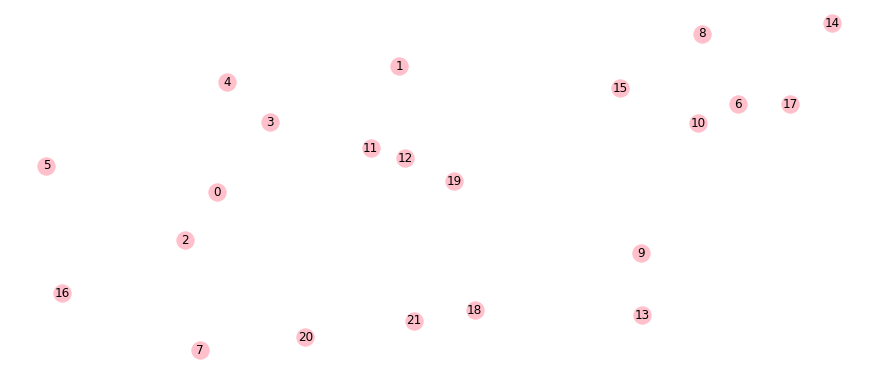

In [16]:
NUM_CITIES = 22

problem = Tsp(NUM_CITIES)
problem.plot()

# Solutions

## Simple Heuristic

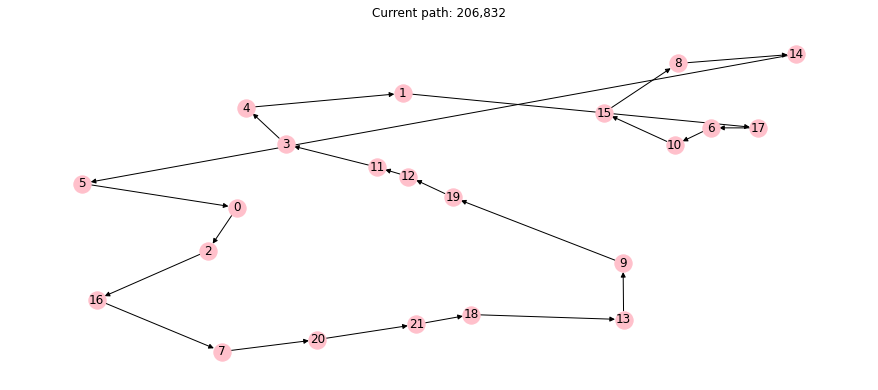

In [17]:
G = nx.Graph()
G.add_nodes_from(problem.graph.nodes())
for n1, n2, _ in sorted(
    [(n1, n2, problem.distance(n1, n2)) for n1, n2 in permutations(problem.graph.nodes(), 2)],
    key=lambda t: t[2],
):
    if len(G.edges(n1)) < 2 and len(G.edges(n2)) < 2:
        G.add_edge(n1, n2)
        try:
            nx.find_cycle(G)
            G.remove_edge(n1, n2)
        except:
            pass

G.add_edge(*[n for n in G if len(G.edges(n)) < 2])
solution = np.array([0] + [n[0] for n in nx.dfs_successors(G, 0).values()])
problem.plot(solution)

## Random-Mutation Hill Climber

In [18]:
def tweak(solution: np.array, *, pm: float = 1 / NUM_CITIES) -> np.array:
    new_solution = solution.copy()
    p = None
    while p is None or p < pm:
        i1 = np.random.randint(0, NUM_CITIES)
        i2 = np.random.randint(0, NUM_CITIES)
        temp = new_solution[i1]
        new_solution[i1] = new_solution[i2]
        new_solution[i2] = temp
        p = np.random.random()
    return new_solution

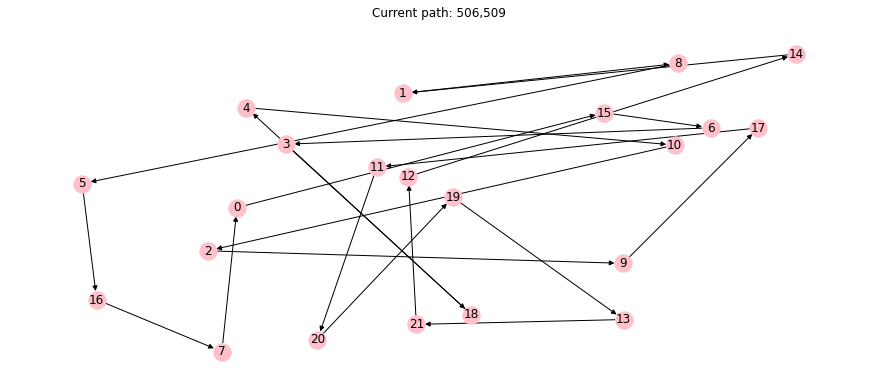

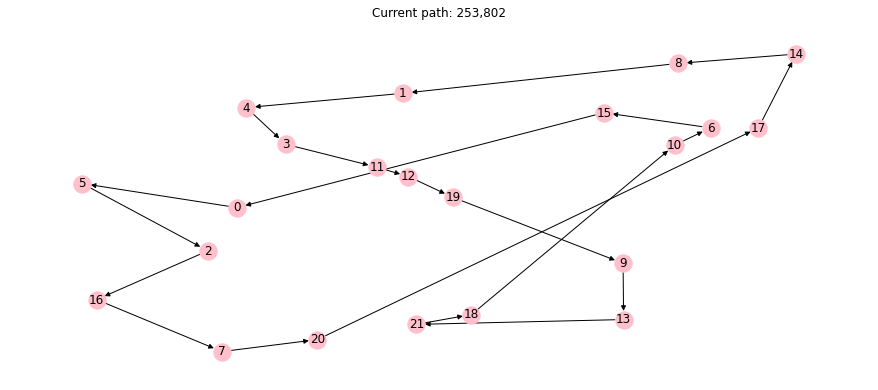

In [19]:
STEADY_STATE = 1000

solution = np.array(range(NUM_CITIES))
np.random.shuffle(solution)
solution_cost = problem.evaluate_solution(solution)
problem.plot(solution)

history = [(0, solution_cost)]
steady_state = 0
step = 0
while steady_state < STEADY_STATE:
    step += 1
    steady_state += 1
    new_solution = tweak(solution, pm=0.5)
    new_solution_cost = problem.evaluate_solution(new_solution)
    if new_solution_cost < solution_cost:
        solution = new_solution
        solution_cost = new_solution_cost
        history.append((step, solution_cost))
        steady_state = 0
problem.plot(solution)

## Iterated Local Search

Written by Lise Martine Cottin ([@Lise26](https://github.com/Lise26/tsp))

In [20]:
def iterated_local_search(problem, solution):
    # Parameters
    g = 8
    temp = 1000

    # Local search to get a local optimum
    cost, sol = iterative_improvement(problem, solution)

    # Best solution found so far
    best_sol, best_cost = sol, cost

    nb_iter = 0
    while nb_iter < problem._num_cities / 2:
        # Perturbation
        sol_prime = perturb(sol, g)
        # Local search to get a new local optimum (starts from sol_prime)
        cost_second, sol_second = iterative_improvement(problem, sol_prime)

        # Acceptance criterion : Metropolis distribution
        # If the cost generated by the second solution is lower, we keep it and restart the loop from it
        if cost_second < cost:
            sol = sol_second
            cost = cost_second
            # Update the best solution if needed
            if cost < best_cost:
                best_sol = sol
                best_cost = cost

        # If not, we will accept a worse solution with a probability depending on how worse the new solution is
        else:
            prob = np.exp((cost - cost_second) / temp)
            if np.random.choice([True, False], p=[prob, 1 - prob]):
                sol = sol_second
                cost = cost_second

        nb_iter += 1

    return best_cost, best_sol


# Iterative improvement algorithm
def iterative_improvement(problem, solution):
    initial_solution = solution
    initial_cost = problem.evaluate_solution(initial_solution)

    # Loop until we find a local minima
    while True:
        sol, cost = first_improvement(initial_solution, problem, initial_cost)
        if cost == initial_cost:
            break
        initial_solution = sol
        initial_cost = cost
    return cost, sol


# Retrieve the first improving neighbor
def first_improvement(sol, instance, value):
    for i in range(0, NUM_CITIES):
        for j in range(1, NUM_CITIES):
            perm = exchange(sol, i, j)
            cost = problem.evaluate_solution(perm)
            if cost < value:
                return perm, cost
    return sol, value


# Perturbation function
def perturb(sol, g):
    for i in range(g):
        sol = get_random_neighbor(sol)
    return sol


# Return a random neighbour belonging to the exchange neighbourhood
def get_random_neighbor(sol):
    neighborhood = []
    for i in range(1, len(sol)):
        for j in range(1, len(sol)):
            neighborhood.append(exchange(sol, i, j))

    # Choose a neighbour at random
    indexes = np.arange(len(neighborhood))
    index = np.random.choice(indexes)
    return neighborhood[index]


# Exchange item on index 1 with item on index 2
def exchange(sol, index1, index2):
    perm = np.copy(sol)
    perm[index1] = sol[index2]
    perm[index2] = sol[index1]
    return perm

Initial solution


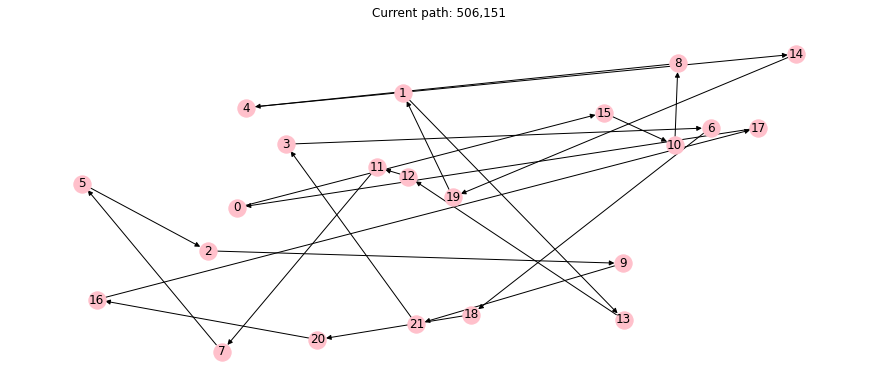

In [21]:
solution = np.array(range(NUM_CITIES))
np.random.shuffle(solution)
print("Initial solution")
problem.plot(solution)

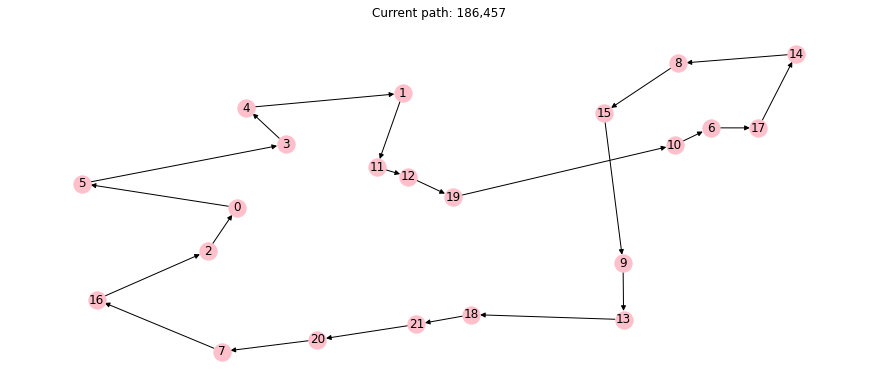

In [22]:
costs = [problem.evaluate_solution(solution)]
while len(costs) < 2 or costs[-1] != costs[-2]:
    l1st_cost, solution = iterated_local_search(problem, solution)
    costs.append(l1st_cost)

problem.plot(solution)

<BarContainer object of 2 artists>

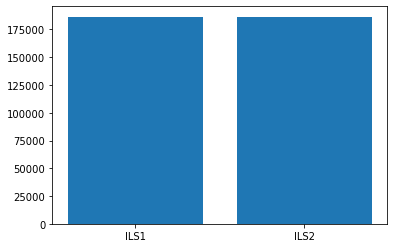

In [23]:
plt.bar([f"ILS{n+1}" for n in range(len(costs) - 1)], costs[1:])

## Genetic Algorithm

Written by Giuseppe Gallipoli

In [24]:
NUM_CITIES = 22
POPULATION_SIZE = NUM_CITIES // 2
OFFSPRING_SIZE = int(np.round(NUM_CITIES * 1.5))
TOURNAMENT_SIZE = 2
ELITE_SIZE = int(np.round(POPULATION_SIZE * 0.1))
STEADY_STATE = 5_000

In [25]:
def parent_selection(population):
    tournament = population[np.random.randint(0, len(population), size=(TOURNAMENT_SIZE,))]
    fitness = np.array([problem.evaluate_solution(p) for p in tournament])
    return np.copy(tournament[fitness.argmin()])


def tweak(solution: np.array, *, pm: float = 1 / NUM_CITIES) -> np.array:
    new_solution = solution.copy()
    p = None
    while p is None or p < pm:
        i1 = np.random.randint(0, NUM_CITIES)
        i2 = np.random.randint(0, NUM_CITIES)
        temp = new_solution[i1]
        new_solution[i1] = new_solution[i2]
        new_solution[i2] = temp
        p = np.random.random()
    return new_solution


def inversion(solution: np.array, *, pm: float = 1 / NUM_CITIES) -> np.array:
    new_solution = solution.copy()
    p = np.random.random()
    if p < pm:
        i1 = np.random.randint(0, NUM_CITIES)
        i2 = np.random.randint(0, NUM_CITIES)
        if i1 > i2:
            i2, i1 = i1, i2
        to_invert = solution[i1 : i2 + 1]
        if len(to_invert) > 0:
            if i1 == 0:
                new_solution[i2::-1] = to_invert
            else:
                new_solution[i2 : i1 - 1 : -1] = to_invert
    return new_solution


def insert(solution: np.array, *, pm: float = 1 / NUM_CITIES) -> np.array:
    new_solution = solution.copy()
    p = np.random.random()
    if p < pm:
        i1 = np.random.randint(0, NUM_CITIES)
        i2 = np.random.randint(0, NUM_CITIES)
        if i1 > i2:
            i2, i1 = i1, i2
        to_move = solution[i1 + 1 : i2]
        if len(to_move) > 0:
            new_solution[i1 + 1] = solution[i2]
            new_solution[i1 + 2 : i2 + 1] = to_move
    return new_solution


def ordxover(p1, p2):
    i1, i2 = int(np.random.random() * len(p1)), int(np.random.random() * len(p2))
    start, end = min(i1, i2), max(i1, i2)
    off_p1 = np.array(p1[start : end + 1])
    off_p2 = np.array([item for item in p2 if item not in off_p1])
    off = np.concatenate((off_p1, off_p2))
    return off

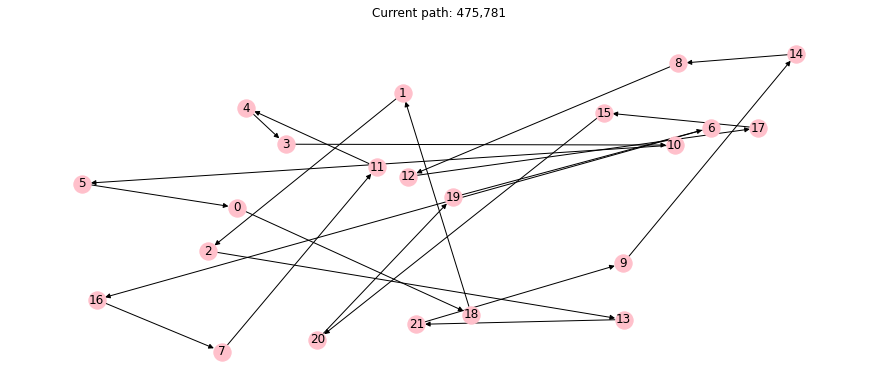

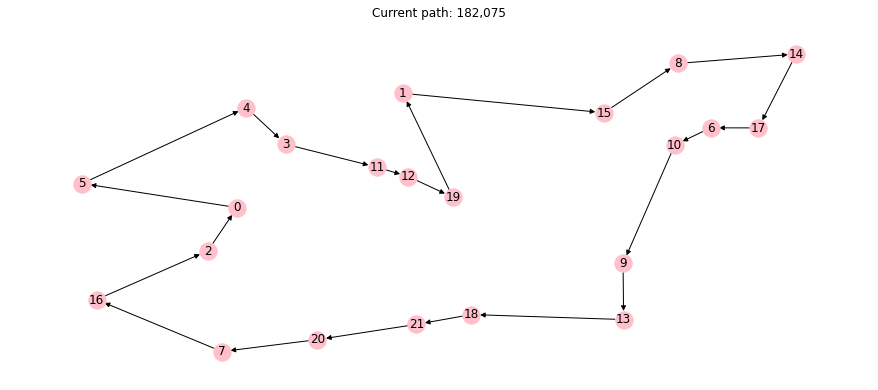

In [26]:
population = np.tile(np.array(range(NUM_CITIES)), (POPULATION_SIZE, 1))
generations = 1

for i in range(POPULATION_SIZE):
    np.random.shuffle(population[i])
solution_costs = [problem.evaluate_solution(population[i]) for i in range(POPULATION_SIZE)]
global_best_solution = population[np.argmin(solution_costs)]
global_best_fitness = problem.evaluate_solution(global_best_solution)

problem.plot(global_best_solution)

history = [(0, global_best_fitness)]
steady_state = 0
step = 0

while steady_state < STEADY_STATE:
    step += 1
    steady_state += 1
    generations += 1
    offspring = list()
    for o in range(OFFSPRING_SIZE // 2):
        p1, p2 = parent_selection(population), parent_selection(population)
        offspring.append(inversion(p1))
        offspring.append(tweak(p2))
        if steady_state > int(0.6 * STEADY_STATE) and np.random.random() < 0.3:
            offspring.append(tweak(ordxover(p1, p2)))
        if steady_state > int(0.6 * STEADY_STATE) and np.random.random() < 0.5:
            offspring.append(insert(p1))
    while len(offspring) < OFFSPRING_SIZE:
        p1 = parent_selection(population)
        offspring.append(tweak(p1))

    offspring = np.array(offspring)
    fitness = [problem.evaluate_solution(o) for o in offspring]
    best_solution = offspring[np.argmin(fitness)]
    best_fitness = problem.evaluate_solution(best_solution)

    if best_fitness < global_best_fitness:
        global_best_solution = best_solution
        global_best_fitness = best_fitness
        history.append((step, global_best_fitness))
        steady_state = 0

    fitness_pop = [problem.evaluate_solution(p) for p in population]
    elite = np.copy(population[np.argsort(fitness_pop)][:ELITE_SIZE])
    best_offspring = np.copy(offspring[np.argsort(fitness)][: POPULATION_SIZE - ELITE_SIZE])
    population = np.concatenate((elite, best_offspring))

problem.plot(global_best_solution)